In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2025-02-26 11:20:40.609550: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740549040.630737   16130 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740549040.637924   16130 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-26 11:20:40.662496: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:

import shutil
from sklearn.model_selection import train_test_split

dataset_path = 'Intel Image Dataset'
all_images = []
all_labels = []

for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        images = [os.path.join(class_path, image_path) for image_path in os.listdir(class_path)]
        all_images.extend(images)
        all_labels.extend([class_name] * len(images))

train_images, test_images, train_labels, test_labels = train_test_split(
    all_images, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)



In [23]:
train_dir = 'train_dir'
test_dir = 'test_dir'

for img, label in zip(train_images, train_labels):
    if os.path.exists(img): 
        os.makedirs(os.path.join(train_dir, label), exist_ok=True)
        shutil.move(img, os.path.join(train_dir, label))
    else:
        print(f"Warning: {img} not found!")

for img, label in zip(test_images, test_labels):
    if os.path.exists(img):  
        os.makedirs(os.path.join(test_dir, label), exist_ok=True)
        shutil.move(img, os.path.join(test_dir, label))
    else:
        print(f"Warning: {img} not found!")

print("Dataset successfully split into train and test sets!")

Dataset successfully split into train and test sets!


In [36]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = "train_dir"
test_dir = "test_dir"

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  
)


train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset="training"
)

val_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset="validation"
)

test_datagen = ImageDataGenerator(rescale=1.0/255)
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 1922 images belonging to 6 classes.
Found 478 images belonging to 6 classes.
Found 600 images belonging to 6 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, MaxPool2D, Flatten, Dense, Conv2D

model = Sequential([
    Conv2D(32, (3,3), activation = 'relu', input_shape = (150,150,3)),
    MaxPool2D(2,2),
    Conv2D(64,(2,2), activation='relu'),
    MaxPool2D(2,2),
    Flatten(),
    Dense(128,activation='relu'),
    Dropout(0.5),
    Dense(6,activation='softmax')
    ])

In [38]:
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    verbose=1
)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [39]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
)


Epoch 1/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 22s 320ms/step - accuracy: 0.2978 - loss: 2.0914 - val_accuracy: 0.5042 - val_loss: 1.2506
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 16s 268ms/step - accuracy: 0.4693 - loss: 1.2838 - val_accuracy: 0.5544 - val_loss: 1.1910
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 24s 402ms/step - accuracy: 0.5431 - loss: 1.1702 - val_accuracy: 0.5565 - val_loss: 1.1491
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 27s 448ms/step - accuracy: 0.5238 - loss: 1.1870 - val_accuracy: 0.5900 - val_loss: 1.0687
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 22s 363ms/step - accuracy: 0.5676 - loss: 1.1016 - val_accuracy: 0.5858 - val_loss: 1.0833
Epoch 6/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 23s 378ms/step - accuracy: 0.5742 - loss: 1.1491 - val_accuracy: 0.6339 - val_loss: 1.0287
Epoch 7/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 21s 350ms/step - accuracy: 0.6107 - loss: 0.9995 - val_accuracy: 0.5879 - val_loss: 1.0568
Epoch 8/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 19s 312ms/step - accuracy: 0.6102 - loss: 1.0222 - val_accu

In [52]:
model.save('intel_image.keras')

2025-02-26 12:38:39.690976: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 42467328 exceeds 10% of free system memory.
2025-02-26 12:38:39.870376: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 42467328 exceeds 10% of free system memory.
2025-02-26 12:38:40.121798: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 42467328 exceeds 10% of free system memory.


In [40]:
test_loss, test_acc = model.evaluate(test_data)
print(f"Test Accuracy: {test_acc:.2f}") 

18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7516 - loss: 0.6831

2025-02-26 12:28:49.472629: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[24,32,148,148]{3,2,1,0}, u8[0]{0}) custom-call(f32[24,3,150,150]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.7464 - loss: 0.6986
Test Accuracy: 0.70


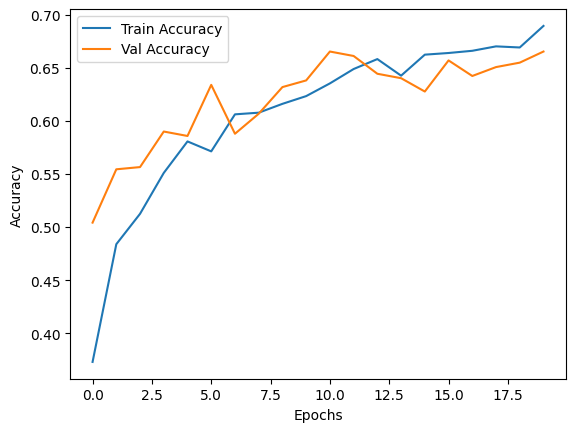

In [41]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [49]:
import numpy as np
from tensorflow.keras.preprocessing import image

img_path = "sea.jpeg"
img = image.load_img(img_path, target_size=(150, 150))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)
predicted_class_index = np.argmax(prediction)

class_labels = {v: k for k, v in train_data.class_indices.items()}  
predicted_class_name = class_labels[predicted_class_index]

print(f"Predicted Class: {predicted_class_name}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted Class: sea
